In [1]:
# Imports
from torch import nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# Accessing GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Loading in data
data = pd.read_csv('ARSS-90-seq+stru.csv', header=None, names=['sequence', 'label', 'structure'])

### Preprocessing
Before training, we must preprocess the data using two methods:

1. **Encoding Amino Acid Sequences**: 
   We convert each amino acid sequence into a list of integers, where each amino acid is represented by a unique integer.

2. **Padding Sequences**: 
   We use PyTorch's `pad_sequence` function to ensure all sequences have a uniform length, adding padding as necessary.

In [4]:
# Encoding sequences
from preprocessing import aa_encode

# Removing unknown amino acids
unknown_aa = ['O', 'U', 'X']

# Create a mask to identify sequences containing any of the unknown amino acids
mask = data['sequence'].apply(lambda seq: any(aa in unknown_aa for aa in seq))

# Filter the DataFrame to keep only the rows where the sequence does not contain any unknown amino acids
data = data[mask == False] 

# Maps amino acids to integers 1-20 (0 will be for padding)
aa_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 
           'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 
           'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}

encoded_sequences = []

for sequence in data['sequence']:
    seq = aa_encode(sequence, aa_map)
    encoded_sequences.append(seq)

data['encoded'] = encoded_sequences

In [5]:
# Splitting data into train, validation, and test sets with 70/15/15 split
train_df, temp_df = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

from ARGDataset import ARGDataset

# Create ARGDatasets
train_dataset = ARGDataset(train_df)
val_dataset = ARGDataset(val_df)
test_dataset = ARGDataset(test_df)

from torch.utils.data import DataLoader
from preprocessing import collate_fn

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [6]:
# Compute greatest sequence length for model parameter
max_len = 0
for idx in range(len(data['encoded']) - 1):
    if len(data['encoded'].iloc[idx]) > max_len:
        max_len = len(data['encoded'].iloc[idx])
print(max_len)

2890


In [7]:
from ARGTransformer import ARGTransformer

# Initialize model
model = ARGTransformer(vocab_size=21, max_seq_length=max_len, embedding_dim=320, num_classes=1, num_heads=4, num_layers=8)

In [8]:
# Training loop
def train_model(model, train_loader, val_loader, epochs, device):
    """
    Trains the model with the given train and validation dataloaders.
    Implements early stopping to avoid overfitting.
    """
    
    # Move model to device
    model.to(device)

    # Define the criterion and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) # 0.00005

    # Early stopping configuration
    patience = 3 # Number of epochs without val loss improvement to stop
    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for sequences, attention_masks, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            # Send data to device
            sequences = sequences.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device).float()
            labels = labels.unsqueeze(1)  # Shape: [batch_size, 1]
            
            # Forward pass
            optimizer.zero_grad()
            # Only taking outputs and not attention maps
            outputs = model(sequences, attention_mask=attention_masks)

            # Compute the loss
            loss = criterion(outputs, labels)
            loss.backward()

            # Optimizer step
            optimizer.step()

            # Accumulate the training loss
            train_loss += loss.item()

        # Average the training loss across all batches
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for sequences, attention_masks, labels in tqdm(val_loader, desc="Validating"):
                # Send validation data to the device
                sequences = sequences.to(device)
                attention_masks = attention_masks.to(device)
                labels = labels.to(device).float()
                labels = labels.unsqueeze(1)  # Shape: [batch_size, 1]

                # Forward pass
                outputs = model(sequences, attention_mask=attention_masks)

                # Compute the loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Average validation loss
        avg_val_loss = val_loss / len(val_loader)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Print metrics for the epoch
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

        # Check for early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered. No improvement in validation loss for several epochs.")
            break

In [9]:
train_model(model, train_loader, val_loader, epochs=30, device=device)

/home/jmontour15/dl_final/preprocessing.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_tensors = [torch.tensor(tokens, dtype=torch.long) for tokens in tokens_list]


alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:03<00:00, 55.39it/s]

Epoch 1 | Train Loss: 0.4159 | Validation Loss: 0.3573




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:03<00:00, 55.99it/s]

Epoch 2 | Train Loss: 0.3501 | Validation Loss: 0.2838




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:03<00:00, 55.36it/s]

Epoch 3 | Train Loss: 0.2935 | Validation Loss: 0.2660




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:03<00:00, 55.66it/s]

Epoch 4 | Train Loss: 0.2550 | Validation Loss: 0.2445




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:03<00:00, 55.22it/s]

Epoch 5 | Train Loss: 0.2177 | Validation Loss: 0.2345




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:04<00:00, 53.37it/s]

Epoch 6 | Train Loss: 0.1836 | Validation Loss: 0.2128




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:03<00:00, 58.85it/s]

Epoch 7 | Train Loss: 0.1559 | Validation Loss: 0.3496




alidating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:03<00:00, 59.18it/s]

Epoch 8 | Train Loss: 0.1367 | Validation Loss: 0.2824



Validating: 100%|█████████████████████████████████████████████████████████████████████| 215/215 [00:03<00:00, 57.46it/s]

Epoch 9 | Train Loss: 0.1135 | Validation Loss: 0.2405
Early stopping triggered. No improvement in validation loss for several epochs.


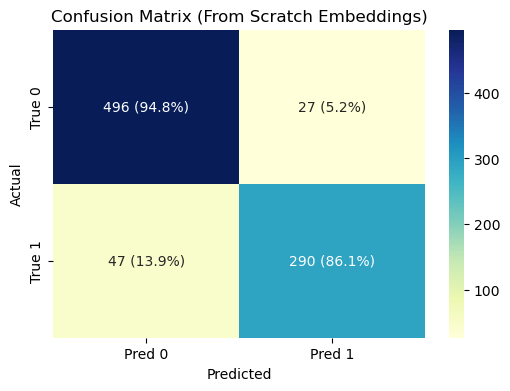

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       523
           1       0.91      0.86      0.89       337

    accuracy                           0.91       860
   macro avg       0.91      0.90      0.91       860
weighted avg       0.91      0.91      0.91       860



In [10]:
from sklearn.metrics import confusion_matrix, classification_report

# Set the model to evaluation mode
model.eval()  

y_true = []
y_pred = []

# Iterate through the test_loader to get true labels and predictions
with torch.no_grad():
    for sequences, attention_masks, labels in test_loader:
        sequences, attention_masks, labels = sequences.to(device), attention_masks.to(device), labels.to(device)
        
        # Forward pass to get predictions
        outputs = model(sequences, attention_mask=attention_masks)
        
        # Apply a threshold to get binary predictions (e.g., if output > 0.5, predict 1; else, predict 0)
        predicted = (outputs > 0.5).float()
        
        # Store true labels and predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Combine total amounts and percentages
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        annot[i, j] = f"{cm[i, j]} ({cm_percentage[i, j]:.1f}%)"

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=annot, fmt='', cmap='YlGnBu', xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (From Scratch Embeddings)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('Figures/ConfusionMatrix_ARGT.png')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

In [11]:
# Get the first batch from the test loader
for batch_idx, (batch_tokens, attention_mask, labels) in enumerate(test_loader):
    if batch_idx == 3:  # Get the first batch
        # Move the batch to the correct device
        batch_tokens = batch_tokens.to(device)
        attention_masks = attention_mask.to(device)

        model.eval()

        # Reset attention maps before forward pass
        model.attention_maps = []

        # Register hook for attention collection
        collect_attention = True
        if collect_attention:
            for attention_layer in model.attention_layers:  # Use attention_layers here
                attention_layer.register_forward_hook(model.save_attention)

        # Perform a forward pass with attention map collection
        with torch.no_grad():
            logits, attention_maps = model(batch_tokens, attention_masks, collect_attention=True)

        # Check if attention maps were collected
        if attention_maps:
            first_sample_attention_maps = attention_maps[0]  # First sample's attention maps
            # Print attention maps shape (for debugging)
            print(f"Shape of attention maps for first sample: {first_sample_attention_maps.shape}")
        else:
            print("No attention maps collected.")
        
        break  # Stop after processing the first batch


Shape of attention maps for first sample: torch.Size([4, 1029, 1029])


/home/jmontour15/dl_final/preprocessing.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_tensors = [torch.tensor(tokens, dtype=torch.long) for tokens in tokens_list]


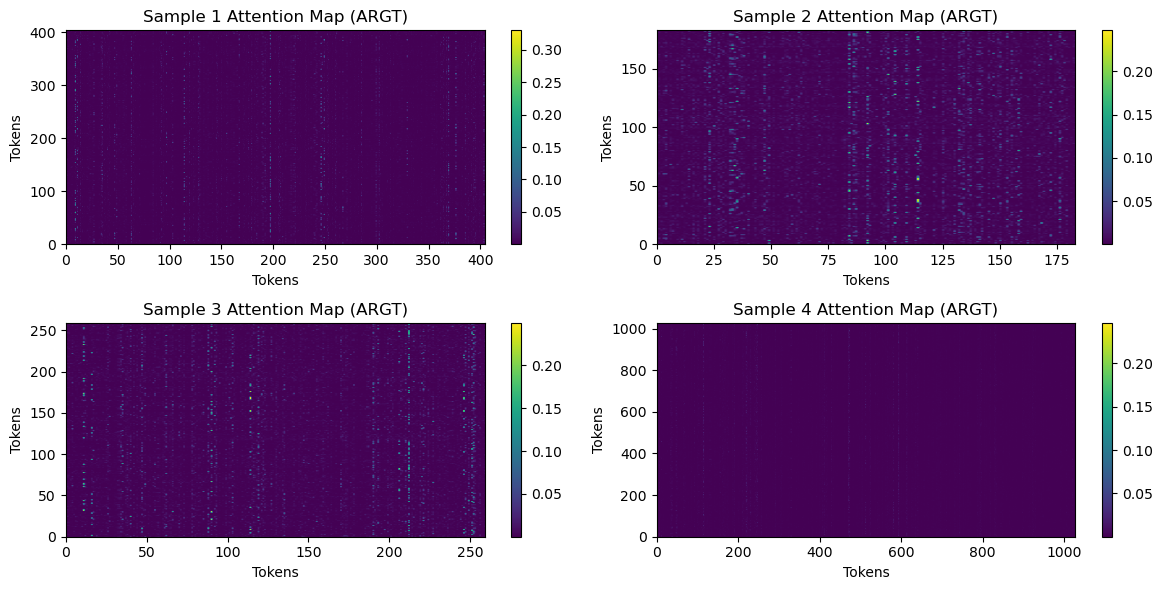

In [12]:
# Gather maps and masks, convert to numpy, and transfer to cpu for easy plotting
attention_maps = [first_sample_attention_maps[i].cpu().numpy() for i in range(4)]
attention_masks = attention_masks.cpu().numpy()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plot each attention map
for idx, ax in enumerate(axes.flat):
    # Get the number of valid tokens from the attention mask (sum of 1s)
    valid_token_count = attention_masks[idx].sum()
    
    # Plot the attention map
    im = ax.imshow(
        attention_maps[idx][:valid_token_count, :valid_token_count],  # Slice to include only valid tokens
        cmap='viridis', 
        aspect='auto'
    )
    ax.set_title(f"Sample {idx + 1} Attention Map (ARGT)")
    
    # Set x-axis and y-axis labels
    ax.set_xlabel("Tokens")
    ax.set_ylabel("Tokens")
    ax.set_xlim(0, valid_token_count - 1)
    ax.set_ylim(0, valid_token_count - 1)
    
    # Add a colorbar for each subplot
    fig.colorbar(im, ax=ax, orientation='vertical')

plt.savefig('Figures/AttentionMaps_ARGT.png')
plt.tight_layout()
plt.show()

### Preparing Data for Model

To train a PyTorch model, the data must be organized into a `Dataset` class and loaded with a `DataLoader`. In this case, our sequences are straightforward, represented as one-dimensional lists of integers. We will then divide this `Dataset` into **Train**, **Validation**, and **Test** sets using a 70/15/15 split.


### Training Model

### Evaluation
Now we will make predictions on the test set and visualize performance with a confusion matrix.